# Проект: Классификация видеороликов 

Студия мультфильмов собирает статистику для оценки популярности различных проектов. И важно агрегировать данные по проектам, а не по отдельным роликам – агрегация статистики по проектам помогает принимать обоснованные бизнес-решения и увеличивать успех новых проектов.

**Задача**:
Нужно создать автоматизированное решение для определения принадлежности видеороликов к проектам на основе анализа текстового описания, субтитров и другой доступной информации.

Тексты могут быть на разных языках, содержать ошибки и опечатки, а также иногда отсутствовать
Ролики одного проекта могут размещаться на разных каналах
Можно с помощью Youtube API использовать дополнительную информацию, но к сожалению не все ролики могут быть обогащены данными (например, лайвы и закрытые каналы)
При разработке надо не только максимизировать метрику, но и создать наиболее гибкое и масштабируемое решение по возможности без ручной разметки


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/animation-reels-classification/sample_submission.csv
/kaggle/input/animation-reels-classification/train.csv
/kaggle/input/animation-reels-classification/test.csv
/kaggle/input/multfilm/df_test_eng.csv
/kaggle/input/multfilm/df_train_eng_full.csv
/kaggle/input/multfilm/df_train_eng_r.csv
/kaggle/input/fork-of-notebookc008874511/__results__.html
/kaggle/input/fork-of-notebookc008874511/df_train_eng_full.csv
/kaggle/input/fork-of-notebookc008874511/__notebook__.ipynb
/kaggle/input/fork-of-notebookc008874511/__output__.json
/kaggle/input/fork-of-notebookc008874511/custom.css
/kaggle/input/fork-of-notebookc008874511/__results___files/__results___9_2.png
/kaggle/input/fork-of-notebookc008874511/__results___files/__results___14_2.png


## Загрузим необходимые библиотеки и определим константыне величины

In [2]:
! pip3 install googletrans==3.1.0a0
!pip install optuna

  Preparing metadata (setup.py) ... - \ | done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 2.3 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16353 sha256=2afdaa5bbf377ee42c73e3c04c3a0e944b606b9aa7c9ad5591dedb1284d4beea
  Stored in directory: /root/.cache/pip/wheels/50/5d/3c/8477d0af4ca2b8b1308812c09f1930863caeebc762fe265a95
Successfully built googletrans
  Attempting uninstall: h11
    Found existing installation: h11 0.14.0
    Uninstalling h11-0.14.0:

In [3]:
from transformers import BertTokenizer, BertModel
from tqdm import notebook
import torch
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.decomposition import PCA

from googletrans import Translator, constants

import optuna
from sklearn.metrics import make_scorer

In [4]:
RANDOM_STATE = 12345
PATH_TRAIN = '/kaggle/input/animation-reels-classification/train.csv' 
PATH_TEST = '/kaggle/input/animation-reels-classification/test.csv'


## Загрузим обучающий и тестовый датасет и получим первичную информацию по дадатсетам, для чего напишем функию download_and_get_info

In [5]:
def download_and_get_info(path):
    '''
    Функция загрузки и первичного анализа данных.
    
    На входе функция принимает:
    path - путь к файлу
    
    На выходе возвращает: df - датасет
    
    Функция обеспечивает загрузку файла в данными, вывод на экран первых пяти строк датасета, 
    вывод общей информации о датасете, количество полных дуюликатов, описание числоовых столбцов, 
    строит гистограммы числовых столбцов, выводит по всем столбцам датасета количество уникальных 
    значений и пропусков
    
    '''
    if os.path.exists(path):
        df = pd.read_csv(path, lineterminator='\n') # загрузка файла
    else:
        print('Something is wrong') 
    df = pd.read_csv(path, lineterminator='\n') # загрузка файла
    display(df.head()) # вывод первых пяти строк датасета
    print('-' * 60)
    df.info() # вывод общей информации о датасете
    print('-' * 60)
    print('Количество полных дубликатов', df.duplicated().sum())
    print('-' * 60)
    print(df.describe())
    df.hist();
    columns = df.columns
    print('-' * 60)
    for column in columns:
        print('-' * 60)
        print(f'столбец {column}')
        print ('Количество уникальных значений', len(df[column].unique()))
        print ('Количество пропусков', df[column].isna().sum())
    return df    

### Обучающающий датасет

,date,reel_name,yt_reel_id,cartoon,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,yt_ch_url,yt_channel_type,flag_closed,international,language
0,2023-12-30,100 подарков и только один можно оставить себе,PyGZL_fCbSc,none,https://www.youtube.com/watch?v=PyGZL_fCbSc,[100 подарков и только один можно оставить себе],1854.0,0.0,none,UCcartHVtvAUzfajflyeT_Gg,Miss Katy,https://www.youtube.com/channel/UCcartHVtvAUzf...,Блогеры,0.0,0.0,NaN
1,2018-06-29,ЗАБАГАЛИ Лизу в Реальной Жизни АРТУР и НАСТЯ F...,Lcp0pFZF4eQ,none,https://www.youtube.com/watch?v=Lcp0pFZF4eQ,[ЗАБАГАЛИ Лизу в Реальной Жизни АРТУР и НАСТЯ ...,602.0,0.0,none,UCWI7puXzGTPuxsoW2HD3XxQ,Boys and Toys,https://youtube.com/channel/UCWI7puXzGTPuxsoW2...,Блогеры,0.0,0.0,NaN
2,2023-11-26,Грозная семейка Лучшие СЕСТРИНСКИЕ моменты с...,z8d6LbiBRnk,none,https://www.youtube.com/watch?v=z8d6LbiBRnk,[Грозная семейка Лучшие СЕСТРИНСКИЕ моменты ...,3604.0,0.0,none,UCw3vK8lNe5SZzL--rMgq-CQ,Nickelodeon_Cyrillic,https://youtube.com/channel/UCw3vK8lNe5SZzL--r...,Мультфильмы,0.0,0.0,NaN
3,2016-05-30,Как сделать ожерелье из ткани своими руками,0iu0p_Y8DjM,none,https://www.youtube.com/watch?v=0iu0p_Y8DjM,[Как сделать ожерелье из ткани своими руками] ...,264.0,0.0,none,UCq1JpGFxcZTbbOAz010U-og,Трум Трум,https://youtube.com/channel/UCq1JpGFxcZTbbOAz0...,Блогеры,0.0,0.0,NaN
4,2023-07-06,Sleepover Rules Om Nom Stories Cartoon for k...,rYwOVp_Edjw,none,https://www.youtube.com/watch?v=rYwOVp_Edjw,[Sleepover Rules Om Nom Stories Cartoon for ...,42899.0,0.0,none,UCniI-BQk7qAtXNmmz40LSdg,Kedoo Toons TV Funny Animations,https://youtube.com/channel/UCniI-BQk7qAtXNmmz...,Мультфильмы,0.0,0.0,NaN


------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83411 entries, 0 to 83410
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             83411 non-null  object 
 1   reel_name        83408 non-null  object 
 2   yt_reel_id       83411 non-null  object 
 3   cartoon          83411 non-null  object 
 4   url              83411 non-null  object 
 5   text             83411 non-null  object 
 6   seconds          74653 non-null  float64
 7   is_shorts        74653 non-null  float64
 8   broadcast        74653 non-null  object 
 9   yt_channel_id    83366 non-null  object 
 10  yt_channel_name  83363 non-null  object 
 11  yt_ch_url        83363 non-null  object 
 12  yt_channel_type  83363 non-null  object 
 13  flag_closed      83363 non-null  float64
 14  international    83363 non-null  float64
 15  language         497 non-null    object 
dt

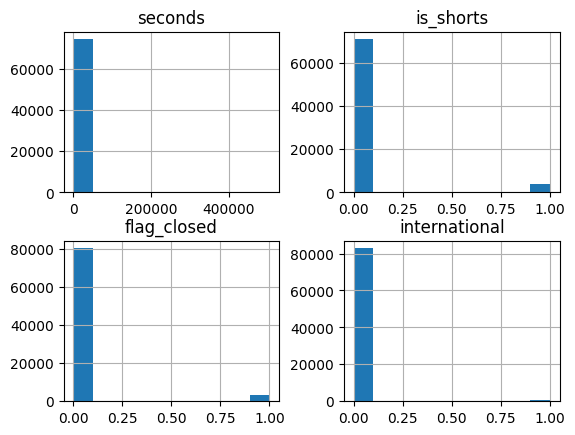

In [6]:
df_train = download_and_get_info(PATH_TRAIN)

Из полученных данных видим, что обучающий датафрейм содержит 83 411 строк и 16 столбцов, полных дубликатов нет. В ряде столбцов (seconds, is-shorts, broadcast, language) наблюдается достаточно большое количество пропусков. Столлбцы - broadcast,is_shorts, flag_closed, international - имеют только два значения 1 и 0, но в них есть пропуски. Для более детального ознакомления с данными посмотрим какие уникальные значения и в каком количестве встречаются в столбцах- 'cartoon',  'yt_channel_type', 'language'

In [7]:
columns_1 = ['cartoon', 'yt_channel_type', 'language']
for column in columns_1:
    print(df_train[column].value_counts()) #normalize=True
    print('-' * 60)

cartoon
none                          78231
Маша и медведь                  853
Говорящий Том                   589
Буба                            529
Кошечки собачки                 437
Енотки                          379
Бэтмен                          353
ЖилаБыла Царевна                229
Оранжевая корова                227
Зебра в клеточку                188
Фиксики                         151
Чик-Чирикино                    137
Сумка                           134
Черепашки Ниндзя                104
Чуддики                          86
My little pony                   81
Свинка Пеппа                     69
Синий трактор                    67
Чучело-Мяучело                   64
Малышарики                       60
Пороро                           51
Приключения Пети и Волка         41
Смешарики                        41
Трансформеры                     40
Простоквашино                    35
Царевны                          32
Щенячий патруль                  32
Cry babies magic tea

В целевой переменной cartoon наблюдается сильный дисбаланс классов, значение none превышает 90%, это надо учесть при разработке решения по калссификации. 
Столбец language - тут мы видим, что в данном столбце пропусков более 99 %, в остальном встречается три языка (английский, испанский и арабский), это также необходимо учесть при разработке решения

### Тестовый датасет

Проводим аналогичные исследования, с учетом того, что в тестовом датасете отсутсвует целевая переменная

,date,reel_name,yt_reel_id,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,yt_ch_url,yt_channel_type,flag_closed,international,language
0,2020-10-26,пять маленьких монстров хэллоуин рифмы потеш...,RBw4j0aMWyM,https://www.youtube.com/watch?v=RBw4j0aMWyM,[пять маленьких монстров хэллоуин рифмы поте...,960.0,0.0,none,UCfeljpDR__qqp-lLBJdiQkw,Kids Tv Russia песенки для дете,https://youtube.com/channel/UCfeljpDR__qqp-lLB...,Детские,0.0,0.0,NaN
1,2024-03-24,Tractor mini Bulldozer to making concrete road...,5wTfpmlZe5k,https://www.youtube.com/watch?v=5wTfpmlZe5k,[Tractor mini Bulldozer to making concrete roa...,0.0,0.0,live,UCIDMp2rLX4G5C6eiypl9SFA,OneDayAlex,https://www.youtube.com/channel/UCIDMp2rLX4G5C...,Блогеры,0.0,0.0,NaN
2,2020-06-28,Кто Последний ПЕРЕСТАНЕТ Ехать Выиграл Челлендж,Fd9YA-oDjSo,https://www.youtube.com/watch?v=Fd9YA-oDjSo,[Кто Последний ПЕРЕСТАНЕТ Ехать Выиграл Челле...,1599.0,0.0,none,UC2tsySbe9TNrI-xh2lximHA,A4,https://youtube.com/channel/UC2tsySbe9TNrI-xh2...,Блогеры,0.0,0.0,NaN
3,2018-07-27,Мультики про машинки и паровозики для детей. Р...,NXCHY_J-5v0,https://www.youtube.com/watch?v=NXCHY_J-5v0,[Мультики про машинки и паровозики для детей. ...,467.0,0.0,none,UC_J_9-qRfVtKIkq7SxxVbhQ,ТВ Деткам,https://youtube.com/channel/UC_J_9-qRfVtKIkq7S...,Детские,0.0,0.0,NaN
4,2021-04-03,СЛИШКОМ МАЛЕНЬКИЙ ПОРТАЛ В ЭНД В МАЙНКРАФТ ТОЛ...,XM-GRekoYzs,https://www.youtube.com/watch?v=XM-GRekoYzs,[СЛИШКОМ МАЛЕНЬКИЙ ПОРТАЛ В ЭНД В МАЙНКРАФТ ТО...,364.0,0.0,none,UCSmqZkD74x3TLt6eRM5GhTg,Dargas,https://youtube.com/channel/UCSmqZkD74x3TLt6eR...,Блогеры,0.0,0.0,NaN


------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55608 entries, 0 to 55607
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             55608 non-null  object 
 1   reel_name        55605 non-null  object 
 2   yt_reel_id       55608 non-null  object 
 3   url              55608 non-null  object 
 4   text             55608 non-null  object 
 5   seconds          49807 non-null  float64
 6   is_shorts        49807 non-null  float64
 7   broadcast        49807 non-null  object 
 8   yt_channel_id    55584 non-null  object 
 9   yt_channel_name  55580 non-null  object 
 10  yt_ch_url        55580 non-null  object 
 11  yt_channel_type  55580 non-null  object 
 12  flag_closed      55580 non-null  float64
 13  international    55580 non-null  float64
 14  language         337 non-null    object 
dtypes: float64(4), object(11)
memory usage: 6.4

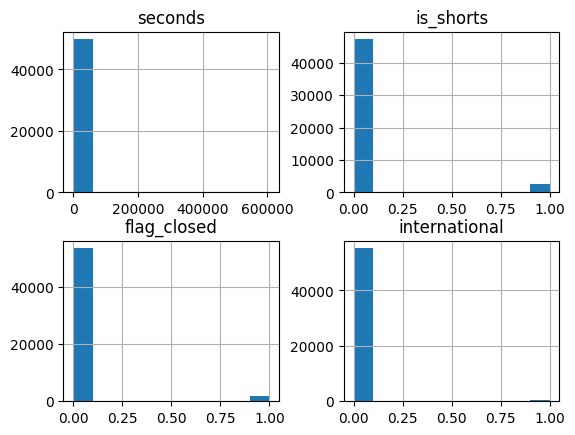

In [8]:
df_test = download_and_get_info(PATH_TEST)

In [9]:
columns_2 = ['yt_channel_type', 'language']
for column in columns_2:
    print(df_test[column].value_counts()) #normalize=True
    print('-' * 60)

yt_channel_type
Мультфильмы    27009
Блогеры        22084
Детские         6348
Shorts           139
Name: count, dtype: int64
------------------------------------------------------------
language
english    145
spanish    137
arabic      55
Name: count, dtype: int64
------------------------------------------------------------


Из полученных данных видим, что тестовый датафрейм содержит 55608  строк и 15 столбцов (отсутвует столбец с целевой переменной cartoon), полных дубликатов нет. В данных наблюдается схожая с обучающей выборкой картина. В столбцах seconds, is-shorts, broadcast, language достаточно большое количество пропусков. Столлбцы - broadcast,is_shorts, flag_closed, international - имеют только два значения 1 и 0, но в них есть пропуски. Также поммимо пропусков в столбце language есть три значения языка (английский, испанский и арабский), аналогично обучающей выборке. Уникальные значения в столбце yt_channel_type в обучающей и тестовой выборках также совпадают.

**Вывод:** Провели загрузку данных и первичное ознакомление с ними. Видим что структура данных обучающей и тестовой выборки совпадают, за исключением столбца cartoon, который является целевой переменной и отсутсвует в тестовой выборкен. В данных нет полных дубликатов, присутвуют пропуски, которые для отдельных признаков надо попробовать обработать. В целевой переменной наблюдается сильный дисбаланс классов и предварительно в данных присутсвуют тексты на 3 языках (английский, испанский, арабский), это необходимо учесть при разработке решения для классификации.

### Посмотрим sample_submission.csv 

In [10]:
submission_sampl = pd.read_csv('/kaggle/input/animation-reels-classification/sample_submission.csv')
submission_sampl.head()

,yt_reel_id,cartoon
0,RBw4j0aMWyM,Бегемотик
1,5wTfpmlZe5k,Космохомяк
2,Fd9YA-oDjSo,Улитка
3,NXCHY_J-5v0,Космохомяк
4,XM-GRekoYzs,Космохомяк


## Проведем исследовательский анализ данных и по необходимости обработаем пропуски

### Обучающая выборка

#### Посмотрим данные, в котрых отсутсвуют название ролика

In [11]:
df = df_train.query('reel_name.isna()')

In [12]:
df_train.query('yt_channel_id == "UCfBtfDbuAH6tZnb-Q9EzauA"')

,date,reel_name,yt_reel_id,cartoon,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,yt_ch_url,yt_channel_type,flag_closed,international,language
61,2021-10-27,Лев играет в свои любимые игрушки. Веселое дет...,2wi_Yd-yFnI,none,https://www.youtube.com/watch?v=2wi_Yd-yFnI,[Лев играет в свои любимые игрушки. Веселое де...,221.0,0.0,none,UCfBtfDbuAH6tZnb-Q9EzauA,LEV family SHOW RUS,https://youtube.com/channel/UCfBtfDbuAH6tZnb-Q...,Блогеры,0.0,0.0,NaN
337,2022-05-31,Мы в машине и детская песенка Колеса у автобус...,pb4jQl18ISM,none,https://www.youtube.com/watch?v=pb4jQl18ISM,[Мы в машине и детская песенка Колеса у автобу...,137.0,0.0,none,UCfBtfDbuAH6tZnb-Q9EzauA,LEV family SHOW RUS,https://youtube.com/channel/UCfBtfDbuAH6tZnb-Q...,Блогеры,0.0,0.0,NaN
993,2020-06-05,Лев и папа и их веселые истории,KL3CoVnBpow,none,https://www.youtube.com/watch?v=KL3CoVnBpow,[Лев и папа и их веселые истории] Сборник весе...,375.0,0.0,none,UCfBtfDbuAH6tZnb-Q9EzauA,LEV family SHOW RUS,https://youtube.com/channel/UCfBtfDbuAH6tZnb-Q...,Блогеры,0.0,0.0,NaN
1676,2023-03-23,Изучаем транспорт и спецтехнику. Обучающее вид...,pyW5WJlseKs,none,https://www.youtube.com/watch?v=pyW5WJlseKs,[Изучаем транспорт и спецтехнику. Обучающее ви...,342.0,0.0,none,UCfBtfDbuAH6tZnb-Q9EzauA,LEV family SHOW RUS,https://youtube.com/channel/UCfBtfDbuAH6tZnb-Q...,Блогеры,0.0,0.0,NaN
2386,2021-04-30,Стикероспа пришла в наш дом. Пришлось вызвать ...,j_GwpJC6J-M,none,https://www.youtube.com/watch?v=j_GwpJC6J-M,[Стикероспа пришла в наш дом. Пришлось вызвать...,316.0,0.0,none,UCfBtfDbuAH6tZnb-Q9EzauA,LEV family SHOW RUS,https://youtube.com/channel/UCfBtfDbuAH6tZnb-Q...,Блогеры,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79680,2022-11-09,Прилипло shorts,SuVCJhFB_Ys,none,https://www.youtube.com/watch?v=SuVCJhFB_Ys,[Прилипло shorts] Что то прилипла к лицуЦелое...,16.0,1.0,none,UCfBtfDbuAH6tZnb-Q9EzauA,LEV family SHOW RUS,https://youtube.com/channel/UCfBtfDbuAH6tZnb-Q...,Блогеры,0.0,0.0,NaN
80241,2020-06-18,Лев и история про Монстра под кроватью / Monst...,xxGvagkLwwc,none,https://www.youtube.com/watch?v=xxGvagkLwwc,[Лев и история про Монстра под кроватью / Mons...,129.0,0.0,none,UCfBtfDbuAH6tZnb-Q9EzauA,LEV family SHOW RUS,https://youtube.com/channel/UCfBtfDbuAH6tZnb-Q...,Блогеры,0.0,0.0,NaN
80996,2023-01-23,Лёва и Алиса и их волшебный рисунок. Детская в...,6RoaGJNqYXQ,none,https://www.youtube.com/watch?v=6RoaGJNqYXQ,[Лёва и Алиса и их волшебный рисунок. Детская ...,345.0,0.0,none,UCfBtfDbuAH6tZnb-Q9EzauA,LEV family SHOW RUS,https://youtube.com/channel/UCfBtfDbuAH6tZnb-Q...,Блогеры,0.0,0.0,NaN
81919,2020-04-18,Лев и папа играют в Лего и другие истории,VEq4qyyqPqE,none,https://www.youtube.com/watch?v=VEq4qyyqPqE,[Лев и папа играют в Лего и другие истории] Сб...,603.0,0.0,none,UCfBtfDbuAH6tZnb-Q9EzauA,LEV family SHOW RUS,https://youtube.com/channel/UCfBtfDbuAH6tZnb-Q...,Блогеры,0.0,0.0,NaN


In [13]:
df_train.query('yt_channel_id == "UCfBtfDbuAH6tZnb-Q9EzauA" & cartoon!="none"')

,date,reel_name,yt_reel_id,cartoon,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,yt_ch_url,yt_channel_type,flag_closed,international,language
12457,2022-06-28,"Лев и Семья с детской песенкой ""Акулёнок"" весе...",l6q-bD-dhso,Акуленок,https://www.youtube.com/watch?v=l6q-bD-dhso,"[Лев и Семья с детской песенкой ""Акулёнок"" вес...",132.0,0.0,none,UCfBtfDbuAH6tZnb-Q9EzauA,LEV family SHOW RUS,https://youtube.com/channel/UCfBtfDbuAH6tZnb-Q...,Блогеры,0.0,0.0,NaN


In [14]:
df_train.query('yt_channel_id == "UCUT1XWGIx6MxWmtPsGYcBEg"')

,date,reel_name,yt_reel_id,cartoon,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,yt_ch_url,yt_channel_type,flag_closed,international,language
57,2021-08-21,simple dimple/pop it/estresse boll/marbo mexe,_q-AIA4CwCE,none,https://www.youtube.com/watch?v=_q-AIA4CwCE,[simple dimple/pop it/estresse boll/marbo mexe],NaN,NaN,NaN,UCUT1XWGIx6MxWmtPsGYcBEg,Bush Baby World Пушастики,https://www.youtube.com/channel/UCUT1XWGIx6MxW...,Мультфильмы,0.0,0.0,NaN
63,2022-03-01,ami meus Fidgets créditos para Chik Fidget sho...,VF07-IQb-s0,none,https://www.youtube.com/watch?v=VF07-IQb-s0,[ami meus Fidgets créditos para Chik Fidget sh...,NaN,NaN,NaN,UCUT1XWGIx6MxWmtPsGYcBEg,Bush Baby World Пушастики,https://www.youtube.com/channel/UCUT1XWGIx6MxW...,Мультфильмы,0.0,0.0,NaN
73,2022-03-15,mágica com meus Fidgets shorts fidgettoys popit,8t9pYfw9RAs,none,https://www.youtube.com/watch?v=8t9pYfw9RAs,[mágica com meus Fidgets shorts fidgettoys pop...,NaN,NaN,NaN,UCUT1XWGIx6MxWmtPsGYcBEg,Bush Baby World Пушастики,https://www.youtube.com/channel/UCUT1XWGIx6MxW...,Мультфильмы,0.0,0.0,NaN
106,2023-01-09,fazendo a lancheira das babys,qIwRDGKs1cU,none,https://www.youtube.com/watch?v=qIwRDGKs1cU,[fazendo a lancheira das babys] shortsviral sh...,NaN,NaN,NaN,UCUT1XWGIx6MxWmtPsGYcBEg,Bush Baby World Пушастики,https://www.youtube.com/channel/UCUT1XWGIx6MxW...,Мультфильмы,0.0,0.0,NaN
117,2022-12-08,minhas miçangas organizadas,57HD54a4rD8,none,https://www.youtube.com/watch?v=57HD54a4rD8,[minhas miçangas organizadas] shortsviral shor...,NaN,NaN,NaN,UCUT1XWGIx6MxWmtPsGYcBEg,Bush Baby World Пушастики,https://www.youtube.com/channel/UCUT1XWGIx6MxW...,Мультфильмы,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82980,2022-02-03,Dimple digeti Mundo da soh,HuMTBRk64Zk,none,https://www.youtube.com/watch?v=HuMTBRk64Zk,[Dimple digeti Mundo da soh],NaN,NaN,NaN,UCUT1XWGIx6MxWmtPsGYcBEg,Bush Baby World Пушастики,https://www.youtube.com/channel/UCUT1XWGIx6MxW...,Мультфильмы,0.0,0.0,NaN
83215,2022-12-08,pulseira nova,KtVZCL2FrdI,none,https://www.youtube.com/watch?v=KtVZCL2FrdI,[pulseira nova] shortsviral shorts deixaolike ...,NaN,NaN,NaN,UCUT1XWGIx6MxWmtPsGYcBEg,Bush Baby World Пушастики,https://www.youtube.com/channel/UCUT1XWGIx6MxW...,Мультфильмы,0.0,0.0,NaN
83244,2022-04-14,ensinando a como fazer macacão em comemoração ...,P1JSnDMxmRM,none,https://www.youtube.com/watch?v=P1JSnDMxmRM,[ensinando a como fazer macacão em comemoração...,NaN,NaN,NaN,UCUT1XWGIx6MxWmtPsGYcBEg,Bush Baby World Пушастики,https://www.youtube.com/channel/UCUT1XWGIx6MxW...,Мультфильмы,0.0,0.0,NaN
83352,2022-07-04,Untitled video,s65LNXrQ5pU,none,https://www.youtube.com/watch?v=s65LNXrQ5pU,[Untitled video],NaN,NaN,NaN,UCUT1XWGIx6MxWmtPsGYcBEg,Bush Baby World Пушастики,https://www.youtube.com/channel/UCUT1XWGIx6MxW...,Мультфильмы,0.0,0.0,NaN


In [15]:
df_train.query('yt_channel_id == "UCUT1XWGIx6MxWmtPsGYcBEg" & cartoon!="none"')

,date,reel_name,yt_reel_id,cartoon,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,yt_ch_url,yt_channel_type,flag_closed,international,language


In [16]:
df_train.shape

(83411, 16)

#### Посмотри зависимость между id канала и целевой переменной

In [17]:
df_train.pivot_table(index=['yt_channel_id', 'yt_channel_name','cartoon'], values='yt_reel_id', aggfunc='count')


yt_reel_id
yt_channel_id            yt_channel_name                 cartoon                   
UC-Bc-4nV2-Tk4Af2rqrmrjA HomeAnimations Мультики про тан none                   748
UC-C8a01ToQqaNCozQbNa9pg Мультфильмы Серия Kids Cartoons none                   230
                                                         Свинка Пеппа             4
UC-jHNWViReG6R_kJ6b45FdQ Family Box                      My little pony           1
                                                         none                   778
...                                                                             ...
UCxWkNmkeAL52VTJyBlIJRXw Теремок ТВ                      Сумка                    3
                                                         Трансформеры            20
                                                         Царевны                  3
UCy1D4WGprdBxv0FaC6IH-wg Лум Планет                      none                   624
UCzHZHO-Z_fR56iOpGWNgzfQ Короткая анимация               none                   559

[399 rows x 1 columns]

In [18]:
df_train['international'].unique()

array([ 0.,  1., nan])

#### Заполним пропуски в столбце internatonal 2, что для наc означает unknown

In [19]:
df_train['international'] = df_train['international'].fillna(2)

In [20]:
df_train['international'].unique()

array([0., 1., 2.])

In [21]:
df_train.query('international == 1.').pivot_table(index=['yt_channel_id', 'yt_channel_name','cartoon'], values='yt_reel_id', aggfunc='count')

,,,yt_reel_id
yt_channel_id,yt_channel_name,cartoon,
UCHIRpb4QywIbwW_wfXjxvXQ,Енотки (arabic),Енотки,92
UCWQjC5G2bSBarItYFvDL8VA,Енотки (spanish),Енотки,122
UCsRz0yA3rhAHT32oWuIp-ow,Енотки (eng),Енотки,113
UCwi1TkxjFSzu6xSONS46_ZQ,Оранжевая корова (eng),Оранжевая корова,91
UCwpkLDoTh4pm4Lojk9tGWTQ,Оранжевая корова (spanish),Оранжевая корова,79


In [22]:
df_train.query('international.isna() & ~(yt_channel_id.isna())')

,date,reel_name,yt_reel_id,cartoon,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,yt_ch_url,yt_channel_type,flag_closed,international,language


In [23]:
df_train.query('yt_channel_name == "Котёнок Котэ Песенки и мультики"')['cartoon'].unique()

array(['none', 'Акуленок'], dtype=object)

#### Заполним пропуски в признаке yt_channel_id на unknown

In [24]:
df_train['yt_channel_id'] = df_train['yt_channel_id'].fillna('unknown')
display(df_train['yt_channel_id'].isna().sum())

0

#### Переведен на английский два признака reel_name и text на английский в обучаующей и тестовой выборке
Предварительно написав функции для обной строки (на вход она получает строку датасета, переводит на английский содержимое столбца, еа выходе возвращает перевод, если не получается перевести, то значение unknownю затем датасеты с обучающими и тестовыми данными сохраняем в новые файлы и далее работаем с ними.

In [25]:
translator = Translator()

In [26]:
def get_translate (row):
    try:
        translation_name = translator.translate(row['reel_name'], dest="en")
        return translation_name.text
    except:
        return "unknown"

In [27]:
def get_translate_1 (row):
    try:
        translation_text = translator.translate(row['text'], dest="en")
        return translation_text.text
    except:
        return "unknown"

In [28]:
df_train.info()

In [29]:
df_train['reel_name_eng'] = df_train.apply(get_translate, axis=1)

In [30]:
df_train['text_eng'] = df_train.apply(get_translate_1, axis=1)

In [31]:
df_train.to_csv('df_train_eng_full.csv', index=False)

In [33]:
df_test['reel_name_eng'] = df_test.apply(get_translate, axis=1)

In [34]:
df_test['text_eng'] = df_test.apply(get_translate_1, axis=1)

In [35]:
df_test.to_csv('df_test_eng.csv', index=False)

### Загрузим новый датасет с переводм на английский для обучающей выборки, посмотрим общую информацию и поверим все ли данные переведены

In [36]:
df_train_eng = pd.read_csv('/kaggle/input/multfilm/df_train_eng_full.csv', lineterminator='\n')

In [37]:
df_train_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83411 entries, 0 to 83410
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             83411 non-null  object 
 1   reel_name        83408 non-null  object 
 2   yt_reel_id       83411 non-null  object 
 3   cartoon          83411 non-null  object 
 4   url              83411 non-null  object 
 5   text             83411 non-null  object 
 6   seconds          74653 non-null  float64
 7   is_shorts        74653 non-null  float64
 8   broadcast        74653 non-null  object 
 9   yt_channel_id    83411 non-null  object 
 10  yt_channel_name  83363 non-null  object 
 11  yt_ch_url        83363 non-null  object 
 12  yt_channel_type  83363 non-null  object 
 13  flag_closed      83363 non-null  float64
 14  international    83411 non-null  float64
 15  language         497 non-null    object 
 16  reel_name_eng    83411 non-null  object 
 17  text_eng    

### Загрузим новый датасет с переводм на английский для тестовой выборки, посмотрим общую информацию и поверим все ли данные переведены

### Тестовая выборка

In [38]:
df_test_eng = pd.read_csv('/kaggle/input/multfilm/df_test_eng.csv', lineterminator='\n')

In [39]:
df_test_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55608 entries, 0 to 55607
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             55608 non-null  object 
 1   reel_name        55605 non-null  object 
 2   yt_reel_id       55608 non-null  object 
 3   url              55608 non-null  object 
 4   text             55608 non-null  object 
 5   seconds          49807 non-null  float64
 6   is_shorts        49807 non-null  float64
 7   broadcast        49807 non-null  object 
 8   yt_channel_id    55584 non-null  object 
 9   yt_channel_name  55580 non-null  object 
 10  yt_ch_url        55580 non-null  object 
 11  yt_channel_type  55580 non-null  object 
 12  flag_closed      55580 non-null  float64
 13  international    55580 non-null  float64
 14  language         337 non-null    object 
 15  reel_name_eng    55608 non-null  object 
 16  text_eng         55608 non-null  object 
dtypes: float64(4

## Увеличим количество признаков попробовав достать из названия роликов на оригиналбном языке именнованные сущности

In [40]:
!pip install spacy==3.8.0

Reason for being yanked: model compatibility problem
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 41.2 MB/s eta 0:00:00
  Attempting uninstall: spacy
    Found existing installation: spacy 3.7.6
    Uninstalling spacy-3.7.6:
      Successfully uninstalled spacy-3.7.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-lg 3.7.1 requires spacy<3.8.0,>=3.7.2, but you have spacy 3.8.0 which is incompatible.
en-core-web-sm 3.7.1 requires spacy<3.8.0,>=3.7.2, but you have spacy 3.8.0 which is incompatible.


In [41]:
import spacy

In [42]:
from spacy.lang.ru.examples import sentences 

In [43]:
nlpsp_eng = spacy.load('en_core_web_sm')

/opt/conda/lib/python3.10/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.7.1) was trained with spaCy v3.7.2 and may not be 100% compatible with the current version (3.8.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [44]:
def get_named_entities(text):
    try:
        doc = nlpsp_eng(text)
        named_entities = [X.text for X in doc.ents]
        return named_entities
    except:
        return 'no'

In [45]:
df_train_eng['name_ent'] = df_train_eng['reel_name_eng'].apply(get_named_entities)

In [46]:
df_train_eng.head()

,date,reel_name,yt_reel_id,cartoon,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,yt_ch_url,yt_channel_type,flag_closed,international,language,reel_name_eng,text_eng,name_ent
0,2023-12-30,100 подарков и только один можно оставить себе,PyGZL_fCbSc,none,https://www.youtube.com/watch?v=PyGZL_fCbSc,[100 подарков и только один можно оставить себе],1854.0,0.0,none,UCcartHVtvAUzfajflyeT_Gg,Miss Katy,https://www.youtube.com/channel/UCcartHVtvAUzf...,Блогеры,0.0,0.0,NaN,100 gifts and only one you can keep for yourself,[100 gifts and only one you can keep],"[100, only one]"
1,2018-06-29,ЗАБАГАЛИ Лизу в Реальной Жизни АРТУР и НАСТЯ F...,Lcp0pFZF4eQ,none,https://www.youtube.com/watch?v=Lcp0pFZF4eQ,[ЗАБАГАЛИ Лизу в Реальной Жизни АРТУР и НАСТЯ ...,602.0,0.0,none,UCWI7puXzGTPuxsoW2HD3XxQ,Boys and Toys,https://youtube.com/channel/UCWI7puXzGTPuxsoW2...,Блогеры,0.0,0.0,NaN,BUGGED Lisa in Real Life ARTHUR and NASTYA Fol...,[LIZA BUGGED in Real Life ARTHUR and NASTYA Fo...,[]
2,2023-11-26,Грозная семейка Лучшие СЕСТРИНСКИЕ моменты с...,z8d6LbiBRnk,none,https://www.youtube.com/watch?v=z8d6LbiBRnk,[Грозная семейка Лучшие СЕСТРИНСКИЕ моменты ...,3604.0,0.0,none,UCw3vK8lNe5SZzL--rMgq-CQ,Nickelodeon_Cyrillic,https://youtube.com/channel/UCw3vK8lNe5SZzL--r...,Мультфильмы,0.0,0.0,NaN,The Terrible Family Best SISTERLY moments with...,[Terrible Family Best SISTER moments with Chlo...,"[SISTERLY, Chloe, Phoebe, Nora, The Terrible F..."
3,2016-05-30,Как сделать ожерелье из ткани своими руками,0iu0p_Y8DjM,none,https://www.youtube.com/watch?v=0iu0p_Y8DjM,[Как сделать ожерелье из ткани своими руками] ...,264.0,0.0,none,UCq1JpGFxcZTbbOAz010U-og,Трум Трум,https://youtube.com/channel/UCq1JpGFxcZTbbOAz0...,Блогеры,0.0,0.0,NaN,How to make a fabric necklace with your own hands,[How to make a fabric necklace with your own h...,[]
4,2023-07-06,Sleepover Rules Om Nom Stories Cartoon for k...,rYwOVp_Edjw,none,https://www.youtube.com/watch?v=rYwOVp_Edjw,[Sleepover Rules Om Nom Stories Cartoon for ...,42899.0,0.0,none,UCniI-BQk7qAtXNmmz40LSdg,Kedoo Toons TV Funny Animations,https://youtube.com/channel/UCniI-BQk7qAtXNmmz...,Мультфильмы,0.0,0.0,NaN,Sleepover Rules Om Nom Stories Cartoon for k...,[Sleepover Rules Om Nom Stories Cartoon for ...,[Kedoo Toons TV]


In [47]:
df_train_eng.to_csv('df_train_eng_ent.csv', index=False)

In [48]:
df_test_eng['name_ent'] = df_test_eng['reel_name_eng'].apply(get_named_entities)

In [49]:
df_test_eng.head()

,date,reel_name,yt_reel_id,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,yt_ch_url,yt_channel_type,flag_closed,international,language,reel_name_eng,text_eng,name_ent
0,2020-10-26,пять маленьких монстров хэллоуин рифмы потеш...,RBw4j0aMWyM,https://www.youtube.com/watch?v=RBw4j0aMWyM,[пять маленьких монстров хэллоуин рифмы поте...,960.0,0.0,none,UCfeljpDR__qqp-lLBJdiQkw,Kids Tv Russia песенки для дете,https://youtube.com/channel/UCfeljpDR__qqp-lLB...,Детские,0.0,0.0,NaN,five little monsters halloween rhymes nursery ...,[five little monsters halloween rhymes nursery...,"[five, Kids Tv, Russia]"
1,2024-03-24,Tractor mini Bulldozer to making concrete road...,5wTfpmlZe5k,https://www.youtube.com/watch?v=5wTfpmlZe5k,[Tractor mini Bulldozer to making concrete roa...,0.0,0.0,live,UCIDMp2rLX4G5C6eiypl9SFA,OneDayAlex,https://www.youtube.com/channel/UCIDMp2rLX4G5C...,Блогеры,0.0,0.0,NaN,Tractor mini Bulldozer to making concrete road...,[Tractor mini Bulldozer to making concrete roa...,"[Bulldozer, Road Roller]"
2,2020-06-28,Кто Последний ПЕРЕСТАНЕТ Ехать Выиграл Челлендж,Fd9YA-oDjSo,https://www.youtube.com/watch?v=Fd9YA-oDjSo,[Кто Последний ПЕРЕСТАНЕТ Ехать Выиграл Челле...,1599.0,0.0,none,UC2tsySbe9TNrI-xh2lximHA,A4,https://youtube.com/channel/UC2tsySbe9TNrI-xh2...,Блогеры,0.0,0.0,NaN,Who is the Last to STOP DRIVING Won the Challenge,[Who is the Last to STOP DRIVING Won the Chall...,[]
3,2018-07-27,Мультики про машинки и паровозики для детей. Р...,NXCHY_J-5v0,https://www.youtube.com/watch?v=NXCHY_J-5v0,[Мультики про машинки и паровозики для детей. ...,467.0,0.0,none,UC_J_9-qRfVtKIkq7SxxVbhQ,ТВ Деткам,https://youtube.com/channel/UC_J_9-qRfVtKIkq7S...,Детские,0.0,0.0,NaN,Cartoons about cars and trains for children. E...,[Cartoons about cars and trains for children. ...,[]
4,2021-04-03,СЛИШКОМ МАЛЕНЬКИЙ ПОРТАЛ В ЭНД В МАЙНКРАФТ ТОЛ...,XM-GRekoYzs,https://www.youtube.com/watch?v=XM-GRekoYzs,[СЛИШКОМ МАЛЕНЬКИЙ ПОРТАЛ В ЭНД В МАЙНКРАФТ ТО...,364.0,0.0,none,UCSmqZkD74x3TLt6eRM5GhTg,Dargas,https://youtube.com/channel/UCSmqZkD74x3TLt6eR...,Блогеры,0.0,0.0,NaN,TOO SMALL PORTAL TO END IN MINECRAFT ONLY 1 PL...,[TOO SMALL PORTAL TO END IN MINECRAFT ONLY 1 P...,[]


In [50]:
df_test_eng.to_csv('df_test_eng_ent.csv', index=False)